# Number of vertical blocks chosen by the ILP for different objective functions w.r.t. alpha 

All vertical blocks with columns less than $\alpha$ are chosen as optimum. 
We want to see if vertical blocks are part of the optimal solution, in which case, fixing them
helps to reduce computational resources and to achieve the same solution (or close enough to the optimal value). 

We show this efect for all objective functions. 

1. count the number of vertical blocks in the optimal solution
2. count the number of vertical blocks in the MSA
3. compute the ratio (1)/(2)

Equivalently, we just need to 
1. count nodes used by all sequences in the final graph


In [28]:
import sys
sys.path.append("..")

import json
import seaborn as sns 
import pandas as pd

from pathlib import Path
from collections import defaultdict, namedtuple
# from src.graph.load_gfa import load_gfa
from src.graph.info_from_gfa import load_info_graph
from src.utils.params_from_path import params_from_path
from src.utils.info_from_exp import get_info_from_exp

from src.graph.load_gfa import load_gfa

import numpy as np
import matplotlib.pyplot as plt

In [29]:
NSEQS =50
NAME = f"{NSEQS}-sars-cov-2-ena"
PATH_SAVE = Path(f"/data/analysis-paper/output-paper-vertical-blocks-optimum/sars-cov-2-{NSEQS}")
PATH_SAVE.mkdir(exist_ok=True, parents=True)

PATH_EXPERIMENTS=Path("/data/analysis-paper/paper-experiment-decomposition")

In [30]:
OBJ_FUNCTIONS = ["blocks", "weighted", "depth", "strings","pen_strings"]
OBJ_FUNCTIONS = ["nodes", "weighted", "depth", "strings","depth_and_len"]
MIN_LEN = [0, 20]
MIN_COVERAGE = [0.0, 0.3]
DECOMPOSITION = "complete"
# DECOMPOSITION = "row_maximal"

## Nodes used by all sequences

In [36]:
path_graph = Path(f"/data/analysis-paper/paper-experiment-decomposition/sars-cov-2-50-{DECOMPOSITION}/gfa-unchop/strings/penalization0-min_len0-min_coverage0-alpha61/50-sars-cov-2-ena.gfa")

In [37]:
load_info_graph(path_gfa=path_graph)

{'n_vertices': 976,
 'n_edges': 1408,
 'len_graph': 60765,
 'potential_seeds_len15': 53633,
 'potential_seeds_len20': 51425,
 'potential_seeds_len25': 49258,
 'nodes_depth_gt_011': 0.507172131147541,
 'nodes_depth_gt_015': 0.5040983606557377,
 'nodes_depth_gt_02': 0.4948770491803279,
 'nodes_depth_gt_025': 0.492827868852459,
 'nodes_depth_gt_03': 0.49077868852459017}

In [38]:
nodes, edges, paths, node_depth  = load_gfa(path_graph)


In [40]:
len(dict(filter(lambda x: x[1] == 1. , node_depth.items())))

229

In [44]:
list_path_gfa=list(Path(f"/data/analysis-paper/paper-experiment-decomposition/sars-cov-2-50-{DECOMPOSITION}/gfa-unchop/").rglob("*.gfa"))

In [71]:
info = []
for path_gfa in list_path_gfa:

    # print(path_gfa.stem)
    obj_function = path_gfa.parent.parent.stem

    penalization, min_len, min_coverage, alpha = str(path_gfa.parent).split("/")[-1].split("-")
    # path_gfa.glob("*json")


    penalization = int(penalization.replace("penalization",""))
    min_len = int(min_len.replace("min_len",""))
    min_coverage = min_coverage.replace("min_coverage","")
    alpha = int(alpha.replace("alpha",""))

    # print(penalization, min_len, min_coverage, alpha)

    # contar bloques verticales en cada solucion 
    # cargar cada json de los subMSA y sumar sus bloques verticales
    n_vertical_blocks = 0
    for submsa_solution in list(path_gfa.glob("*json")):
        
        with open(submsa_solution,"r") as fp:
            blocks_submsa = json.load(fp)
            vertical_blocks_submsa = [b for b in blocks_submsa if len(b[0]) == NSEQS]
            n_vertical_blocks += len(vertical_blocks_submsa)
    # print(obj_function, penalization, min_len, min_coverage, alpha, n_vertical_blocks)
    

    nodes, edges, paths, node_depth  = load_gfa(path_gfa)
    
    nodes_full_depth = len(dict(filter(lambda x: x[1] == 1. , node_depth.items())))


    info.append(
        dict(
            objective_function=obj_function,
            penalization=penalization,
            min_len=min_len,
            min_coverage=min_coverage,
            alpha=alpha,
            vertical_blocks_ilp=n_vertical_blocks,
            path=str(path_gfa),
            nodes_full_depth = nodes_full_depth,
        )
    )
info

[{'objective_function': 'depth',
  'penalization': 1000,
  'min_len': 0,
  'min_coverage': '0.11',
  'alpha': 500,
  'vertical_blocks_ilp': 0,
  'path': '/data/analysis-paper/paper-experiment-decomposition/sars-cov-2-50-complete/gfa-unchop/depth/penalization1000-min_len0-min_coverage0.11-alpha500/50-sars-cov-2-ena.gfa',
  'nodes_full_depth': 153},
 {'objective_function': 'depth',
  'penalization': 1000,
  'min_len': 0,
  'min_coverage': '0.11',
  'alpha': 435,
  'vertical_blocks_ilp': 0,
  'path': '/data/analysis-paper/paper-experiment-decomposition/sars-cov-2-50-complete/gfa-unchop/depth/penalization1000-min_len0-min_coverage0.11-alpha435/50-sars-cov-2-ena.gfa',
  'nodes_full_depth': 156},
 {'objective_function': 'depth',
  'penalization': 1000,
  'min_len': 0,
  'min_coverage': '0.11',
  'alpha': 610,
  'vertical_blocks_ilp': 0,
  'path': '/data/analysis-paper/paper-experiment-decomposition/sars-cov-2-50-complete/gfa-unchop/depth/penalization1000-min_len0-min_coverage0.11-alpha610/50

In [72]:
data = pd.DataFrame(info)

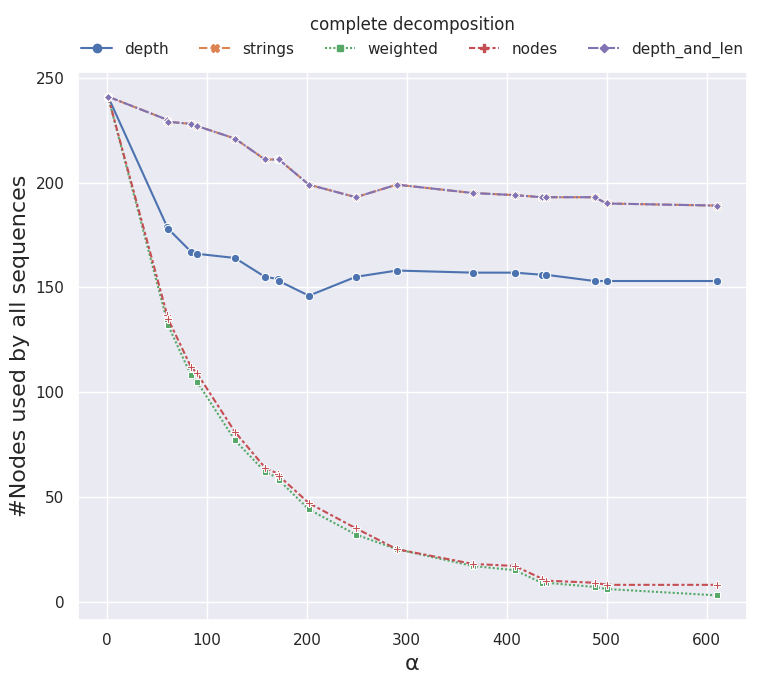

In [75]:
sns.set_theme(style="darkgrid", rc={"figure.figsize": (8,7)})
g_vertical_blocks = sns.lineplot(data=data,
                x="alpha",
                y="nodes_full_depth",
                hue="objective_function",
                style="objective_function",
                markers=True,
                )

g_vertical_blocks.set_xlabel(f"{chr(945)}",fontsize=16)
g_vertical_blocks.set_ylabel("#Nodes used by all sequences",fontsize=16)

decomposition = DECOMPOSITION.replace("_","-")
sns.move_legend(
    g_vertical_blocks, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5,
    title=f"{decomposition} decomposition", 
    frameon=False,
)

plt.tight_layout()

plt.savefig(PATH_SAVE.joinpath(f"{NAME}-vertical-blocks-ilp-{DECOMPOSITION}.png"),dpi=300)

___

Bloques verticales

In [7]:
path_vertical_blocks = Path(f"/data/analysis-paper/paper-experiment-decomposition/sars-cov-2-50-{DECOMPOSITION}/maximal-blocks/50-sars-cov-2-ena/vertical_blocks_alpha1.json")

with open(path_vertical_blocks, "r") as fp: 
    blocks = json.load(fp)

n_vertical_blocks = len(blocks)
n_vertical_blocks

241

In [10]:
from collections import Counter
Counter([b[2]-b[1]+1 for b in blocks])[1]

3

Bloques verticales para cada `\alpha`

In [11]:
list_ilp_solution = list(PATH_EXPERIMENTS.joinpath(f"sars-cov-2-50-complete/ilp/{NSEQS}-sars-cov-2-ena/").glob("*/*"))

In [12]:
list_ilp_solution[0]

PosixPath('/data/analysis-paper/paper-experiment-decomposition/sars-cov-2-50-complete/ilp/50-sars-cov-2-ena/nodes/penalization0-min_len0-min_coverage0-alpha158')

In [13]:
info = []
for ilp_solution in list_ilp_solution:

    # print(ilp_solution.stem)
    obj_function = ilp_solution.parent.stem
    if obj_function == "strings":
        penalization, min_len, min_coverage, alpha = str(ilp_solution).split("/")[-1].split("-")
        # ilp_solution.glob("*json")


        penalization = int(penalization.replace("penalization",""))
        min_len = int(min_len.replace("min_len",""))
        min_coverage = min_coverage.replace("min_coverage","")
        alpha = int(alpha.replace("alpha",""))

        # print(penalization, min_len, min_coverage, alpha)

        # contar bloques verticales en cada solucion 
        # cargar cada json de los subMSA y sumar sus bloques verticales
        n_vertical_blocks = 0
        for submsa_solution in list(ilp_solution.glob("*json")):
            
            with open(submsa_solution,"r") as fp:
                blocks_submsa = json.load(fp)
                vertical_blocks_submsa = [b for b in blocks_submsa if len(b[0]) == NSEQS]
                n_vertical_blocks += len(vertical_blocks_submsa)
        # print(obj_function, penalization, min_len, min_coverage, alpha, n_vertical_blocks)
        
        info.append(
            dict(
                objective_function=obj_function,
                penalization=penalization,
                min_len=min_len,
                min_coverage=min_coverage,
                alpha=alpha,
                vertical_blocks_ilp=n_vertical_blocks,
                path=str(ilp_solution)
            )
        )
info

[{'objective_function': 'strings',
  'penalization': 0,
  'min_len': 0,
  'min_coverage': '0',
  'alpha': 84,
  'vertical_blocks_ilp': 2184,
  'path': '/data/analysis-paper/paper-experiment-decomposition/sars-cov-2-50-complete/ilp/50-sars-cov-2-ena/strings/penalization0-min_len0-min_coverage0-alpha84'},
 {'objective_function': 'strings',
  'penalization': 0,
  'min_len': 0,
  'min_coverage': '0',
  'alpha': 60,
  'vertical_blocks_ilp': 1356,
  'path': '/data/analysis-paper/paper-experiment-decomposition/sars-cov-2-50-complete/ilp/50-sars-cov-2-ena/strings/penalization0-min_len0-min_coverage0-alpha60'},
 {'objective_function': 'strings',
  'penalization': 0,
  'min_len': 0,
  'min_coverage': '0',
  'alpha': 202,
  'vertical_blocks_ilp': 5146,
  'path': '/data/analysis-paper/paper-experiment-decomposition/sars-cov-2-50-complete/ilp/50-sars-cov-2-ena/strings/penalization0-min_len0-min_coverage0-alpha202'},
 {'objective_function': 'strings',
  'penalization': 0,
  'min_len': 0,
  'min_cove

In [14]:
p = Path('/data/analysis-paper/paper-experiment-decomposition/sars-cov-2-50-complete/ilp/50-sars-cov-2-ena/strings/penalization0-min_len0-min_coverage0-alpha84')
info_blocks =  []
list_v_blocks = []
for js in list(p.rglob("*json")):
    with open(js) as fp: 
        blocks = json.load(fp)
        
        v_blocks = [b for b in blocks if len(b[0])==50]
        list_v_blocks.extend(v_blocks)
        
        info_blocks.append(
            dict(
                n_blocks=len(blocks),
                n_vblocks=len(v_blocks),
                )
        )

pd.DataFrame(info_blocks)

,n_blocks,n_vblocks
0,131,73
1,2,0
2,2,0
3,2,0
4,2,0
...,...,...
104,2,0
105,2,0
106,33,29
107,8,2


In [15]:
info_v_blocks = []
for b in list_v_blocks:
    K,b,e,l = b
    info_v_blocks.append(
        dict(start=b,end=e, label=l)
    )
df_v_blocks = pd.DataFrame(info_v_blocks)
df_v_blocks.sort_values("start").head(20)

,start,end,label
1345,379,441,ttatcagaggcacgtcaacatcttaaagatggcacttgtggcttag...
1346,443,516,ttttgcctcaacttgaacagccctatgtgttcatcaaacgttcgga...
31,1059,1059,c
34,1060,1060,t
43,1061,1061,t
44,1062,1062,c
47,1063,1063,a
32,1064,1064,a
57,1065,1065,t
61,1066,1066,g


In [16]:
len(df_v_blocks.start.unique())

2184

In [17]:
data = pd.DataFrame(info)
data["vertical_blocks_ilp_log"] = data["vertical_blocks_ilp"].apply(lambda x: np.log(x+0.1))  
data["objective_function"] = data["objective_function"].apply(lambda x: "blocks" if x=="nodes" else x)
data["objective_function"] = data["objective_function"].apply(lambda x: "pen_strings" if x=="depth_and_len" else x)
data.head()

,objective_function,penalization,min_len,min_coverage,alpha,vertical_blocks_ilp,path,vertical_blocks_ilp_log
0,strings,0,0,0,84,2184,/data/analysis-paper/paper-experiment-decompos...,7.688959
1,strings,0,0,0,60,1356,/data/analysis-paper/paper-experiment-decompos...,7.212368
2,strings,0,0,0,202,5146,/data/analysis-paper/paper-experiment-decompos...,8.545994
3,strings,0,0,0,90,2269,/data/analysis-paper/paper-experiment-decompos...,7.727139
4,strings,0,0,0,366,6543,/data/analysis-paper/paper-experiment-decompos...,8.786166


In [18]:
data.query("vertical_blocks_ilp > 200 and alpha <  128")

,objective_function,penalization,min_len,min_coverage,alpha,vertical_blocks_ilp,path,vertical_blocks_ilp_log
0,strings,0,0,0,84,2184,/data/analysis-paper/paper-experiment-decompos...,7.688959
1,strings,0,0,0,60,1356,/data/analysis-paper/paper-experiment-decompos...,7.212368
3,strings,0,0,0,90,2269,/data/analysis-paper/paper-experiment-decompos...,7.727139
14,strings,0,0,0,61,1357,/data/analysis-paper/paper-experiment-decompos...,7.213105


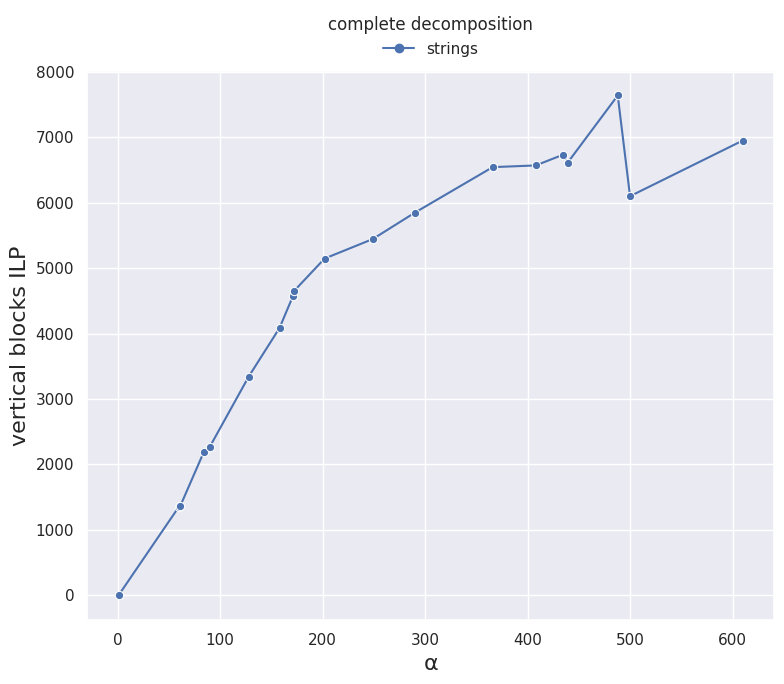

In [19]:
sns.set_theme(style="darkgrid", rc={"figure.figsize": (8,7)})
g_vertical_blocks = sns.lineplot(data=data,
                x="alpha",
                y="vertical_blocks_ilp",
                hue="objective_function",
                style="objective_function",
                markers=True,
                )

g_vertical_blocks.set_xlabel(f"{chr(945)}",fontsize=16)
g_vertical_blocks.set_ylabel("vertical blocks ILP",fontsize=16)

decomposition = DECOMPOSITION.replace("_","-")
sns.move_legend(
    g_vertical_blocks, "lower center",
    bbox_to_anchor=(.5, 1), ncol=5,
    title=f"{decomposition} decomposition", 
    frameon=False,
)

plt.tight_layout()

# plt.savefig(PATH_SAVE.joinpath(f"{NAME}-vertical-blocks-ilp-{DECOMPOSITION}.png"),dpi=300)

In [20]:
data.groupby("objective_function").max()

,penalization,min_len,min_coverage,alpha,vertical_blocks_ilp,path,vertical_blocks_ilp_log
objective_function,,,,,,,
strings,0,0,0,610,7638,/data/analysis-paper/paper-experiment-decompos...,8.940904
